# TaskEnvironment.py Tutorial
(For more info, see `TaskEnvironment_basics.md`)

In [1]:
# Setup and parameters
import numpy as np
import matplotlib.pyplot as plt
from ratinabox.contribs.TaskEnvironment import (SpatialGoalEnvironment, TaskEnvironment, 
                                                SpatialGoal, Reward, Goal, get_goal_vector)
from ratinabox.Agent import Agent
from IPython import display
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Video
import sys
print(sys.executable)


%matplotlib inline
speed = 12 # dials how fast agent runs
pausetime = 0.000001 # pause time in plot
plt.close('all')


/Users/ryoung/opt/anaconda3/envs/ratinabox11/bin/python


# Setting up reward 💰 functions

Configure the reward given for reaching a goal. Some options include setting decay function, decay parameters or an external driving function, e.g. a gradient. Rewards once they're given to an agent remain active until they expire (this is optional).


Text(0.5, 0.98, 'Linear decay reward functions')

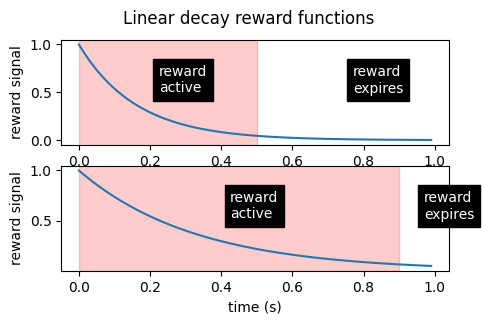

In [2]:
fig, axs = plt.subplots(2,1, figsize=(5,3))
plt.sca(axs[0])
r_exp=Reward(1, expire_clock=0.5, decay="linear", decay_knobs=[6])
r_exp.plot_theoretical_reward()
plt.sca(axs[1])
r_exp2=Reward(1, expire_clock=0.9, decay="linear", decay_knobs=[3])
r_exp2.plot_theoretical_reward()
plt.suptitle('Linear decay reward functions')

Text(0.5, 0.98, 'Constant decay reward function')

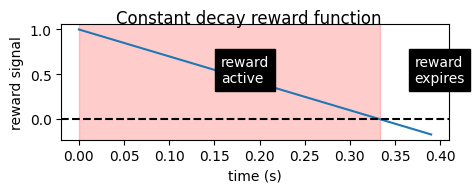

In [3]:
fig, axs = plt.subplots(1,1, figsize=(5,1.5))
plt.sca(axs)
r_con=Reward(1, expire_clock=1/3, decay="constant", decay_knobs=[3])
r_con.plot_theoretical_reward((0,0.4))
plt.axhline([0], c="black", linestyle="dashed")
plt.suptitle('Constant decay reward function')

### 🎯 `Goal` objects are used to 🔍 _detect a condition_ and 💰 _release these `Reward` objects above 👆

`Rewards` come from special objects that merely check for a rule or objective being satisfied: `Goal`s. For example, an agent enters a special region of a maze and receives a reward, a `SpatialGoal`. Later, we will create those and place them into our `TaskEnvironment`. 

# ⚙️ Configuring `TaskEnvironment` with 🐀 `Agent` objects

Let's take the example task environment, `SpatialGoalTaskEnvironment`; it's configured it to work with `SpatialGoal` objects, although you could pass `SpatialGoal` objects to a vanilla `TaskEnvironment`. 

There are two approaches to setting up goals for a task. 
- 🍎 One approach, you make a pool of goal objects yourself and give them to the environment. This is the least opaque.
- 🚀 The other, you allow `SpatialGoalTaskEnvironment` to construct your goals using keyword arguments the `goalkws` passed to `SpatialTaskEnvironment`. This let's it manage creating them for you. New TaskEnvironments have to have the internal machinery (which is fairly lightweight) to automate this.

#### 🍎 Easy example: Manually crafting goals and integrating them into a versatile TaskEnvironment

First, we're going to dive into the most adaptable scenario. We'll be forging our own 🎯 Goal objects, each with a 💰 Reward, and then delivering those goals to a TaskEnvironment or SpatialTaskEnvironment. To start, let's erect a type of TaskEnvironment object.

In [4]:
env = SpatialGoalEnvironment(params={'dimensionality':'2D'},
                             render_every=1, # how often to draw on .render() 
                             teleport_on_reset=False, # teleport animal to new location each episode?
                             verbose=False)

/Users/ryoung/opt/anaconda3/envs/ratinabox11/lib/python3.11/site-packages/ratinabox/utils.py:694: UserWarning: Cannot collect the default_params dictionaries, as SpatialGoalEnvironment does not have the class attribute 'default_params' defined in its preamble. (Can be just an empty dictionary, i.e.: default_params = dict().)
  warnings.warn(
/Users/ryoung/opt/anaconda3/envs/ratinabox11/lib/python3.11/site-packages/ratinabox/utils.py:749: UserWarning: Cannot check the keys in the params dictionary, as <class 'ratinabox.contribs.TaskEnvironment.SpatialGoalEnvironment'> does not have a class attribute 'default_params' defined in its preamble. (Can be just an empty dictionary, i.e.: default_params = dict().)
  warnings.warn(


Now, let's bring some goals to life for our environment. We intialize goals by attaching them to an environment.  In the case of the spatial goals below, they have some default reward (unless you attach your own through `reward=reward`) and take on a random position (unless you provide it through `pos=pos`). 

Here, we generates two spatial goals at random coordinates within the environment 🎲, and one goal that has a precise position (x=0.2, y=0.2) and a reward object `r_con` that's granted upon completion 🎯. The remaining goals will be equipped with the default reward object.


In [5]:
goals = [SpatialGoal(env), SpatialGoal(env),
         SpatialGoal(env, pos=[0.2, 0.2], reward=r_con)]

We're now ready to attach these goals to our task and recruit some agents 🐀.

The render function will illustrate your environment, agents, and anything else that the task environment is programmed to depict. In the case of `SpatialGoalEnvironment`, it's been fine-tuned to showcase spatial goal objects 🎯.

In [6]:
Ag = Agent(env)
env.goal_cache.reset_goals = goals # you can also pass these into goalcachekws of an environment
env.add_agents(Ag)
print("Here are the active agents who have yet to solve the episode goals:", env.agents)
print(f"env.reset() will reset goals from pool of n={len(env.goal_cache.reset_goals)} possible goals")

Here are the active agents who have yet to solve the episode goals: ['agent_0']
env.reset() will reset goals from pool of n=3 possible goals


### `.step()` the environment
we now can make our agents take a step in environment given its state, and the step() will return a set of dictionaries patterned {agent_name:value}. It returns observations the agents make (their states), the rewards per agent, and whether each agent hits a stopping point (if all goals are satisfied this episode for). (See `pettingzoo.env` documentation for more info about the return objects.)

In [7]:
observation, reward, terminate_epi, _ , info = env.step() # Take a single action randomly
print("Observation: ", observation,
      "Reward: ", reward,
      "Terminate episode: ", terminate_epi)

Observation:  {'agent_0': array([0.54666599, 0.3439716 ])} Reward:  {'agent_0': 0} Terminate episode:  {'agent_0': False}


Since we have only _1 agent_, there is a shortcut function `.step1()`. With this call, an environment can behave more like single-agent `Gymnasium` instead of `pettingzoo`, only returning the observation, reward, and halting information for our one agent. Less cumbersome for one agent simulations.

In [8]:
observation, reward, terminate_epi, _ , info = env.step1() # Take a single action randomly
print("Observation: ", observation,
      "Reward: ", reward,
      "Terminate episode: ", terminate_epi)

Observation:  [0.54747371 0.34397705] Reward:  0 Terminate episode:  False


### Animating an episode
Generally, we call step() repeatedly in a while-loop to carry out an epsiode. 

Here, we plan to create a matplotlib animation; so let's instead create a function that draws a single step()! This function "plans" an action, takes the action via .step(), and then `render()` or draws the agents, environment, and goals. 

In [9]:
def animate_update(*pos, **kws):
    dir_to_reward = {name:get_goal_vector(Ag)
                     for name, Ag in env.Ags.items()}
    actions = {agent : speed * Ag.speed_mean * 
            (dir_to_reward / np.linalg.norm(dir_to_reward))
            for (agent, dir_to_reward) in dir_to_reward.items()}
    
    observation, reward, terminate_episode, _, info = \
            env.step(actions)
    
    fig, ax = env.render()
    if any(terminate_episode.values()):
        print("done! reward:", reward)
        env.reset()
        print("starting episode:", env.episode)
        
    return fig

(If we were not using `FuncAnimation` and jupyter here, you could just blurt this function code into a while loop, and we would see a quick live-rendered plot.)

In [10]:
%matplotlib notebook
fig, ax = env.render(); # get the figure and axis
anim = FuncAnimation(fig, animate_update, range(1000), blit=False) # animate 1000 of of the environment-action loop
anim.save('TaskEnv_teaching_example_files/env_primary_interface.mp4', 
          writer='ffmpeg', fps=180)
Video("TaskEnv_teaching_example_files/env_primary_interface.mp4")

<IPython.core.display.Javascript object>

    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again
done! reward: {'agent_0': 1}
starting episode: 2
done! reward: {'agent_0': 1}
starting episode: 3
done! reward: {'agent_0': 1}
starting episode: 4
done! reward: {'agent_0': 1.99}
starting episode: 5
done! reward: {'agent_0': 2.9701}
starting episode: 6
done! reward: {'agent_0': 1}
starting episode: 7
done! reward: {'agent_0': 1}
starting episode: 8
done! reward: {'agent_0': 1.99}
starting episode: 9
done! reward: {'agent_0': 1}
starting episode: 10
done! reward: {'agent_0': 1.99}
starting episode: 11
done! reward: {'agent_0': 1}
starting episode: 12
done! reward: {'agent_0': 1}
starting episode: 13


![My Animation](TaskEnv_teaching_example_files/animation.mp4)

### 🚀 Shortcut to crafting SpatialGoals through a SpatialGoalEnvironment

The derived class, SpatialGoalEnvironment, comes with its own set of convenience functions. These allow you to simply specify the number of goals and provide the construction arguments goalkws. You can also fine-tune features of the goalcache, as we discussed earlier, such as designating whether the goals are sequential or not, or if they're shared among agents 🤖.

In [11]:
goalkws      = dict(reward=r_exp) # Goal.__init__ kws called within Task, we could also just provide `Goal` objects
goalcachekws = dict(reset_n_goals=2,
                    agentmode="noninteract",
                    goalorder="nonsequential") # GoalCache.__init__ kws, these are covered elsewhere
                                               # and can also be used for the 🍎 section
                                               # ie for manually set goal collections

env = SpatialGoalEnvironment(
    teleport_on_reset=False,   # 
    goalkws=goalkws,           # Reward will be attached to the `Goal` object
    goalcachekws=goalcachekws, # Goals will be tracked by the cache
)

# Add our agents to the environment}
Ag = Agent(env)
Ag2 = Agent(env)
env.add_agents(Ag)
env.add_agents(Ag2)
print("Agent names: ",env.agent_names)

Agent names:  ['agent_0', 'agent_1']


/Users/ryoung/opt/anaconda3/envs/ratinabox11/lib/python3.11/site-packages/ratinabox/utils.py:694: UserWarning: Cannot collect the default_params dictionaries, as SpatialGoalEnvironment does not have the class attribute 'default_params' defined in its preamble. (Can be just an empty dictionary, i.e.: default_params = dict().)
  warnings.warn(
/Users/ryoung/opt/anaconda3/envs/ratinabox11/lib/python3.11/site-packages/ratinabox/utils.py:749: UserWarning: Cannot check the keys in the params dictionary, as <class 'ratinabox.contribs.TaskEnvironment.SpatialGoalEnvironment'> does not have a class attribute 'default_params' defined in its preamble. (Can be just an empty dictionary, i.e.: default_params = dict().)
  warnings.warn(


And now let's run the environment :)

In [12]:
%matplotlib notebook
fig, ax = env.render(); # does not return a figure until something happens
anim = FuncAnimation(fig, animate_update, range(1000), blit=False)
anim.save('TaskEnv_teaching_example_files/shortcut_env_spatial.mp4', writer='ffmpeg', fps=180)
Video("TaskEnv_teaching_example_files/shortcut_env_spatial.mp4")

<IPython.core.display.Javascript object>

done! reward: {'agent_0': 1.4849913702741633, 'agent_1': 0}
starting episode: 2
done! reward: {'agent_0': 1, 'agent_1': 0}
starting episode: 3
done! reward: {'agent_0': 1, 'agent_1': 0.8261686238355868}
starting episode: 4
done! reward: {'agent_0': 1.4430479816261728, 'agent_1': 1}
starting episode: 5
done! reward: {'agent_0': 1, 'agent_1': 0}
starting episode: 6
done! reward: {'agent_0': 2.3998609130491433, 'agent_1': 0.8179069375972309}
starting episode: 7


![My Animation](TaskEnv_teaching_example_files/animation.mp4)

# Custom goals

Let's imagine we wanted to create a goal for a virtual rat: to remain still for 2 seconds (some experimental insight: not an easy ask for real rats). We can encode that goal as follows ....

In [13]:
class Stillness(Goal):
    """
    Default `Goal` object that this inherits from takes 
    an environment (which may have agents) and
    a reward they can give to agents 
    """
    def __init__(self, *pos, how_long=2, velocity_thresh=0.5, **kws):
        super().__init__(*pos, **kws)
        self.how_long = how_long  # How long should 🐀 be still?
        self.velocity_thresh = velocity_thresh # What is stillness? How slow?
        self.lastmove = {agent:0 for agent in self.env.Ags} # Store the last movement times
    
    def check(self, agents):
        """
        Now our check method runs over each  🐀 in our environment, checking
        if its speed is below the threshold for stillness, and emits a reward
        if its been still for more than 2 seconds
        """
        successful_agents = []
        for name, agent in selg.env.Ags.items():
            if agent.velocity > self.velocity_thresh:
                self.last_move[name] = agent.t
            if agent.t - self.last_move[name] > self.how_long:
                successful_agents.append(name)
        return {name:reward for name in successful_agents}

# CREATING *NEW* TASKS with new goals 🛠️ 🎨

(Coming soon ...)

More about understanding the structure of TaskEnvironments you can find in [./TaskEnvironment_basics.md](./TaskEnvironment_basics.md)